<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP2</h2></center>

# Importation des librairies

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop, Adamax, Nadam, Adagrad
from keras.api._v2.keras.callbacks import ModelCheckpoint

# Configaration GPU

In [25]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

NVIDIA GeForce RTX 3050


# Importation du dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=True)

170498071/170498071 [==============================] - 311s 2us/step


# Analyse et Visualisation du dataset

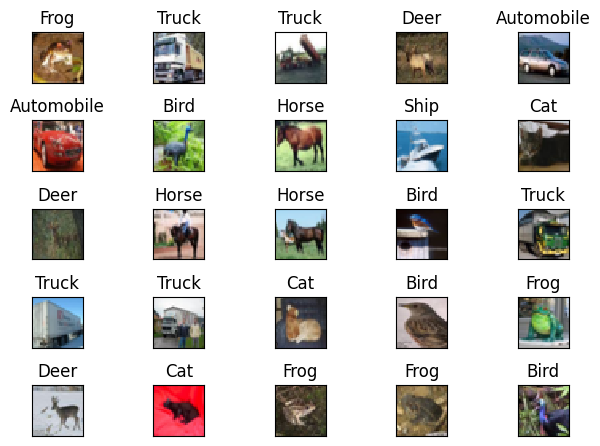

In [4]:
# On affiche des valeurs random de notre dataset
class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title(class_names[y_train[i][0]])
  plt.xticks([])
  plt.yticks([])

Text(0.5, 1.0, 'Distribution des pixels')

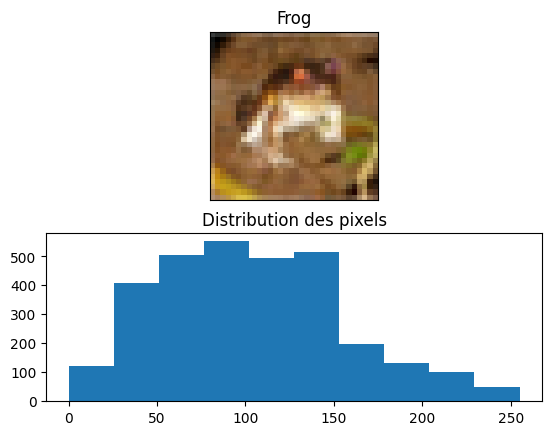

In [5]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title(class_names[y_train[0][0]])
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(3072))
plt.title("Distribution des pixels")

# Prétraitement du Dataset

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

X_train /= 255
X_test /= 255
X_val /= 255

X_train_ANN = X_train.reshape(50000, 3072)
X_test_ANN = X_test.reshape(5000, 3072)
X_val_ANN = X_val.reshape(5000, 3072)

Y_train = to_categorical(y_train, len(class_names))
Y_test = to_categorical(y_test, len(class_names))
Y_val = Y_test = to_categorical(y_val, len(class_names))

In [7]:
print("dimensions des variables indépendantes d'entraintement", X_train.shape)
print("dimensions des variables indépendantes de test", X_test.shape)
print("dimensions des variables indépendantes de validation", X_val.shape)

dimensions des variables indépendantes d'entraintement (50000, 32, 32, 3)
dimensions des variables indépendantes de test (5000, 32, 32, 3)
dimensions des variables indépendantes de validation (5000, 32, 32, 3)


In [8]:
print("Shape after one-hot encoding: ", Y_train.shape)

Shape after one-hot encoding:  (50000, 10)


# Classification du dataset Cifar10 via un ANN

## Initialisation de différents hyper-paramètres

In [ ]:
nb_neurones = [128, 256, 512, 1024]
nb_epoch = [20, 30, 50, 100]
activation_functions = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_size = [16, 32, 64, 128]

titles = ["Nombre de neurones", "Fonction d'activation", "Learning rate", "Batch size", "Nombre d'epoch", "Accuracy", "Loss", "Val_accuracy", "Val_loss"]
gridsearch = []

## Gridsearch pour trouver la meillieure combinaison d'hyper-paramètres de notre ANN

In [ ]:
gridsearch = []
for nbe in nb_epoch:
  for bs in batch_size:
    for learning_rate in learning_rates:
      for activation_function in activation_functions:
        for nbn in nb_neurones:
            with tf.device(device_name):

              model = Sequential()
              model.add(Dense(nbn, input_dim=3072))
              model.add(Activation(activation_function))
              model.add(Dropout(0.2))

              model.add(Dense(nbn))
              model.add(Activation(activation_function))
              model.add(Dropout(0.2))

              model.add(Dense(10))
              model.add(Activation('softmax'))

              model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate))

              history = model.fit(X_train_ANN, Y_train,
                        batch_size=bs, epochs=nbe,
                        verbose=0,
                        validation_data=(X_val_ANN, Y_val))
              
              result = [nbn, activation_function, learning_rate, bs, nbe, history.history['accuracy'][-1], history.history['loss'][-1], history.history['val_accuracy'][-1], history.history['val_loss'][-1]]

              gridsearch.append(result)

In [ ]:
benchmark = pd.DataFrame(data=gridsearch, columns=titles)
benchmark.to_csv('Model results/gridsearch_results_cifar10.csv', index=False)
benchmark

## Analyse des résultats

In [19]:
benchmark = pd.read_csv('Model results/gridsearch_results_cifar10.csv')
# sort it by accuracy
benchmark.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

benchmark.head(10)

,Nombre de neurones,Fonction d'activation,Learning rate,Batch size,Nombre d'epoch,Accuracy,Loss,Val_accuracy,Val_loss
129,512,tanh,0.010,16,30,0.364958,0.002775,0.33900,0.087586
149,512,sigmoid,0.001,16,30,0.364958,0.001126,0.33850,0.095700
51,512,relu,0.001,64,20,0.364958,0.001379,0.33800,0.093711
150,1024,sigmoid,0.001,16,30,0.364958,0.001076,0.33775,0.101379
607,1024,relu,0.010,128,100,0.364958,0.004916,0.33775,0.089247
435,1024,relu,0.010,64,50,0.364958,0.005082,0.33750,0.086127
182,1024,relu,0.010,32,30,0.364958,0.003830,0.33725,0.083955
304,256,relu,0.001,128,30,0.364958,0.003006,0.33675,0.096762
532,512,sigmoid,0.010,16,100,0.364958,0.003644,0.33675,0.095512
12,512,tanh,0.001,32,20,0.364958,0.001078,0.33625,0.094922


On note que quelque soit la combinaisons d'hyper-paramètres les résultats sont très décevants 

### Analyse approfondie de l'impacte des hyperparamètres

#### Nombre de neurones

In [21]:
nbn_df = benchmark.groupby(["Nombre de neurones"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
nbn_df.reset_index(inplace=True)
nbn_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
nbn_df = nbn_df[["Nombre de neurones", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

nbn_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

nbn_df

,Nombre de neurones,Accuracy,Val_accuracy,Ecart loss/val_loss
0,128,0.343653,0.330027,0.122230
1,256,0.343227,0.328676,0.106567
2,512,0.342903,0.329065,0.062912
3,1024,0.342106,0.328961,0.062696


#### Fonction d'activation

In [11]:
fa_df = benchmark.groupby(["Fonction d'activation"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
fa_df.reset_index(inplace=True)
fa_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
fa_df = fa_df[["Fonction d'activation", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

fa_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

fa_df

,Fonction d'activation,Accuracy,Val_accuracy,Ecart loss/val_loss
0,relu,0.992395,0.977932,0.081487
2,tanh,0.988743,0.974650,0.041941
1,sigmoid,0.975718,0.965296,0.071045


#### Learning Rate

In [22]:
lr_df = benchmark.groupby(["Learning rate"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
lr_df.reset_index(inplace=True)
lr_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
lr_df = lr_df[["Learning rate", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

lr_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

lr_df

,Learning rate,Accuracy,Val_accuracy,Ecart loss/val_loss
0,0.0001,0.354635,0.336916,0.122230
1,0.0010,0.353514,0.336858,0.106567
2,0.0100,0.346545,0.331146,0.062912
3,0.1000,0.317195,0.311809,0.062696


#### Batch Size

In [23]:
bs_df = benchmark.groupby(["Batch size"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
bs_df.reset_index(inplace=True)
bs_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
bs_df = bs_df[["Batch size", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

bs_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

bs_df

,Batch size,Accuracy,Val_accuracy,Ecart loss/val_loss
0,16,0.350362,0.334555,0.122230
1,32,0.344399,0.330176,0.106567
2,64,0.342984,0.329116,0.062912
3,128,0.334144,0.322882,0.062696


#### Nombre d'epoch

In [24]:
nbe_df = benchmark.groupby(["Nombre d'epoch"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
nbe_df.reset_index(inplace=True)
nbe_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
nbe_df = nbe_df[["Nombre d'epoch", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

nbe_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

nbe_df

,Nombre d'epoch,Accuracy,Val_accuracy,Ecart loss/val_loss
3,100,0.346372,0.331959,0.062696
2,50,0.343787,0.330768,0.062912
1,30,0.342843,0.329004,0.106567
0,20,0.338887,0.324997,0.122230


# Classification du dataset Cifar10 via un CNN

## Initialisation de différents hyper-paramètres

In [ ]:
nb_param = 4
nb_filtre1 = [1024, 512, 256, 128, 64]
nb_filtre2 = [1024, 512, 256, 128, 64]
nb_epochs = [500, 200, 100, 50, 30, 20]
batch_size = [1024, 512, 256, 128, 64, 32, 16]

## Utilisation d'un algorithme génétique pour trouver la meillieure combinaison d'hyper paramètres

In [ ]:
def init_population(population_size, nb_filtre1, nb_filtre2, nb_epochs, batch_size):
    random.seed(42)
    population = []
    for _ in range(population_size):
        population.append([random.choice(nb_filtre1), random.choice(nb_filtre2), random.choice(nb_epochs), random.choice(batch_size)])
    return population

def select(population, ratio=0.5):
    pop_size = len(population)
    selection_size = int(pop_size * ratio)
    chances = int(pop_size * (pop_size - 1) / 2)

    selection = []
    while len(selection) < selection_size:
        selector = random.randint(0, chances - 1)
        offset = pop_size
        for i in range(pop_size):
            if selector < offset:
                selection.append(population[i].copy())
                break
            else:
                selector -= offset
                offset -= 1
    return selection

def crossover(population, n_rounds):
    pop_size = len(population)

    new_population = []
    while len(new_population) < n_rounds:
        index1 = random.randint(0, pop_size - 1)
        index2 = index1
        while index2 == index1:
            index2 = random.randint(0, pop_size - 1)

        new_individual = []
        pivot = nb_param // 2
        for i in range(pivot):
            new_individual.append(population[index1][i])
        for i in range(pivot, nb_param):
            new_individual.append(population[index2][i])

        
        new_population.append(new_individual)
        
    return new_population

def mutate(population, n_rounds):
    pop_size = len(population)

    if pop_size == 0:
        return

    for _ in range(n_rounds):
        individual_index = random.randint(0, pop_size - 1)
        param_index = random.randint(0, nb_param - 1)
        individual  = population[individual_index].copy()
        hyperparam = [nb_filtre1, nb_filtre2, nb_epochs, batch_size]
        individual[param_index] = random.choice(hyperparam[param_index])

        population[individual_index] = individual

    return population

def evaluate(population, population_size, X_train, Y_train, X_val, Y_val):
    score = []
    i = 0
    for individual in population:
        model = Sequential()

        model.add(Conv2D(individual[0], kernel_size=(3, 3), activation = 'relu', input_shape=(32, 32, 3), padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(0.1))

        model.add(Conv2D(individual[1], kernel_size=(3, 3), activation = 'relu', input_shape=(32, 32, 3), padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(0.3))

        model.add(Flatten())

        model.add(Dense(100, activation='relu'))

        model.add(Dense(10, activation = 'softmax'))

        checkpointer = ModelCheckpoint(filepath='CNN_model_cifar.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', periode=1)
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0, mode='auto', verbose=0)

        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

        history = model.fit(X_train, Y_train,
                    batch_size=individual[3], epochs=individual[2],
                    verbose=2,
                    callbacks=[checkpointer, callback],
                    validation_data=(X_val, Y_val))
        
        score.append([i, (history.history['accuracy'][-1] + history.history['val_accuracy'][-1]) /  (history.history['loss'][-1] - history.history['val_loss'][-1])])
        i += 1
    score.sort(key=lambda x: x[1], reverse=True)

    scored_population = []

    for i in range(population_size):
        scored_population.append(population[score[i][0]])

    if score[0][1] > 0.95:
        return scored_population, True
        
    return scored_population, False

In [ ]:
def genetic_algorithm(nb_iteration, population_size, X_train, Y_train, X_val, Y_val, ratio, crossover_rounds, mutation_rounds):

    population = init_population(nb_filtre1, nb_filtre2, nb_epochs, batch_size)

    for _ in range(nb_iteration):

        selection = select(population, ratio)

        crossed_population = crossover(selection, crossover_rounds)
        
        mutated_population = mutate(crossed_population, mutation_rounds)

        population = population + mutated_population

        population, stop = evaluate(population, population_size, X_train, Y_train, X_val, Y_val)[:10]

        if stop:
            break

    return population[0]

In [26]:
genetic_algorithm(nb_iteration=10, population_size=10, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, ratio=0.5, crossover_rounds=10, mutation_rounds=10)

[1024, 512, 200, 256]

## Test de notre CNN avec plusieurs variations de la version optimal des hyper-paramètres

In [6]:
hyper_parameters = [
    {"nb_filtre1" : 1024, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 256},
    {"nb_filtre1" : 1024, "nb_filtre2": 1024, "nb_epochs" : 200, "batch_size" : 256},
    {"nb_filtre1" : 512, "nb_filtre2": 256, "nb_epochs" : 200, "batch_size" : 256},
    {"nb_filtre1" : 512, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 256},
    {"nb_filtre1" : 1024, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 512},
    {"nb_filtre1" : 1024, "nb_filtre2": 1024, "nb_epochs" : 200, "batch_size" : 512},
    {"nb_filtre1" : 512, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 512},
    {"nb_filtre1" : 512, "nb_filtre2": 256, "nb_epochs" : 200, "batch_size" : 512},
    {"nb_filtre1" : 1024, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 64},
    {"nb_filtre1" : 1024, "nb_filtre2": 1024, "nb_epochs" : 200, "batch_size" : 64},
    {"nb_filtre1" : 512, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 64},
    {"nb_filtre1" : 512, "nb_filtre2": 256, "nb_epochs" : 200, "batch_size" : 64},
    {"nb_filtre1" : 1024, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 1024},
    {"nb_filtre1" : 1024, "nb_filtre2": 1024, "nb_epochs" : 200, "batch_size" : 1024},
    {"nb_filtre1" : 512, "nb_filtre2": 512, "nb_epochs" : 200, "batch_size" : 256},
    {"nb_filtre1" : 512, "nb_filtre2": 256, "nb_epochs" : 200, "batch_size" : 256},
]

In [ ]:
models = []
for hp in hyper_parameters:
    with tf.device(device_name):    
        model = Sequential()

        model.add(Conv2D(hp["nb_filtre1"], kernel_size=(3, 3), activation = 'relu', input_shape=(32, 32, 3), padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(0.1))

        model.add(Conv2D(hp["nb_filtre2"], kernel_size=(3, 3), activation = 'relu', input_shape=(32, 32, 3), padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(0.3))

        model.add(Flatten())

        model.add(Dense(100, activation='relu'))

        model.add(Dense(10, activation = 'softmax'))

        checkpointer = ModelCheckpoint(filepath='CNN_model_cifar.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', periode=1)
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0, mode='auto', verbose=0)

        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

        history = model.fit(X_train, Y_train,
                    batch_size=hp["batch_size"], epochs=hp["nb_epochs"],
                    verbose=0,
                    callbacks=[checkpointer, callback],
                    validation_data=(X_val, Y_val))
        
        models.append([nbn, activation_function, learning_rate, bs, nbe, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']])
        

In [9]:
df_models = []
for m in models:
    df_models.append([m[0], m[1], m[2], m[3], m[4], m[5][-1], m[6][-1], m[7][-1], m[8][-1]])

df_models = pd.DataFrame(data=models, columns=["nb_filtre1", "nb_filtre2", "nb_epochs", "batch_size", "accuracy", "loss", "val_accuracy", "val_loss"])

df_models.sort_values(by=['accuracy'], ascending=[False], inplace=True)

df_models

,nb_filtre1,nb_filtre2,nb_epochs,batch_size,accuracy,loss,val_accuracy,val_loss
0,1024,512,200,256,0.86684,0.374841,0.7312,0.848300
1,1024,1024,200,256,0.86684,0.374841,0.7312,0.848300
2,512,256,200,256,0.86120,0.389387,0.7402,0.823941
3,512,512,200,256,0.86120,0.389387,0.7402,0.823941
4,1024,512,200,512,0.85744,0.401996,0.7370,0.865059
5,1024,1024,200,512,0.85744,0.401996,0.7370,0.865059
6,512,512,200,512,0.84836,0.427814,0.7460,0.793723
7,512,256,200,512,0.84298,0.445105,0.7542,0.760001
8,1024,512,200,64,0.83204,0.469699,0.7362,0.816617
9,1024,1024,200,64,0.83200,0.467781,0.7340,0.834876


## Visualisation et analyses des résultats

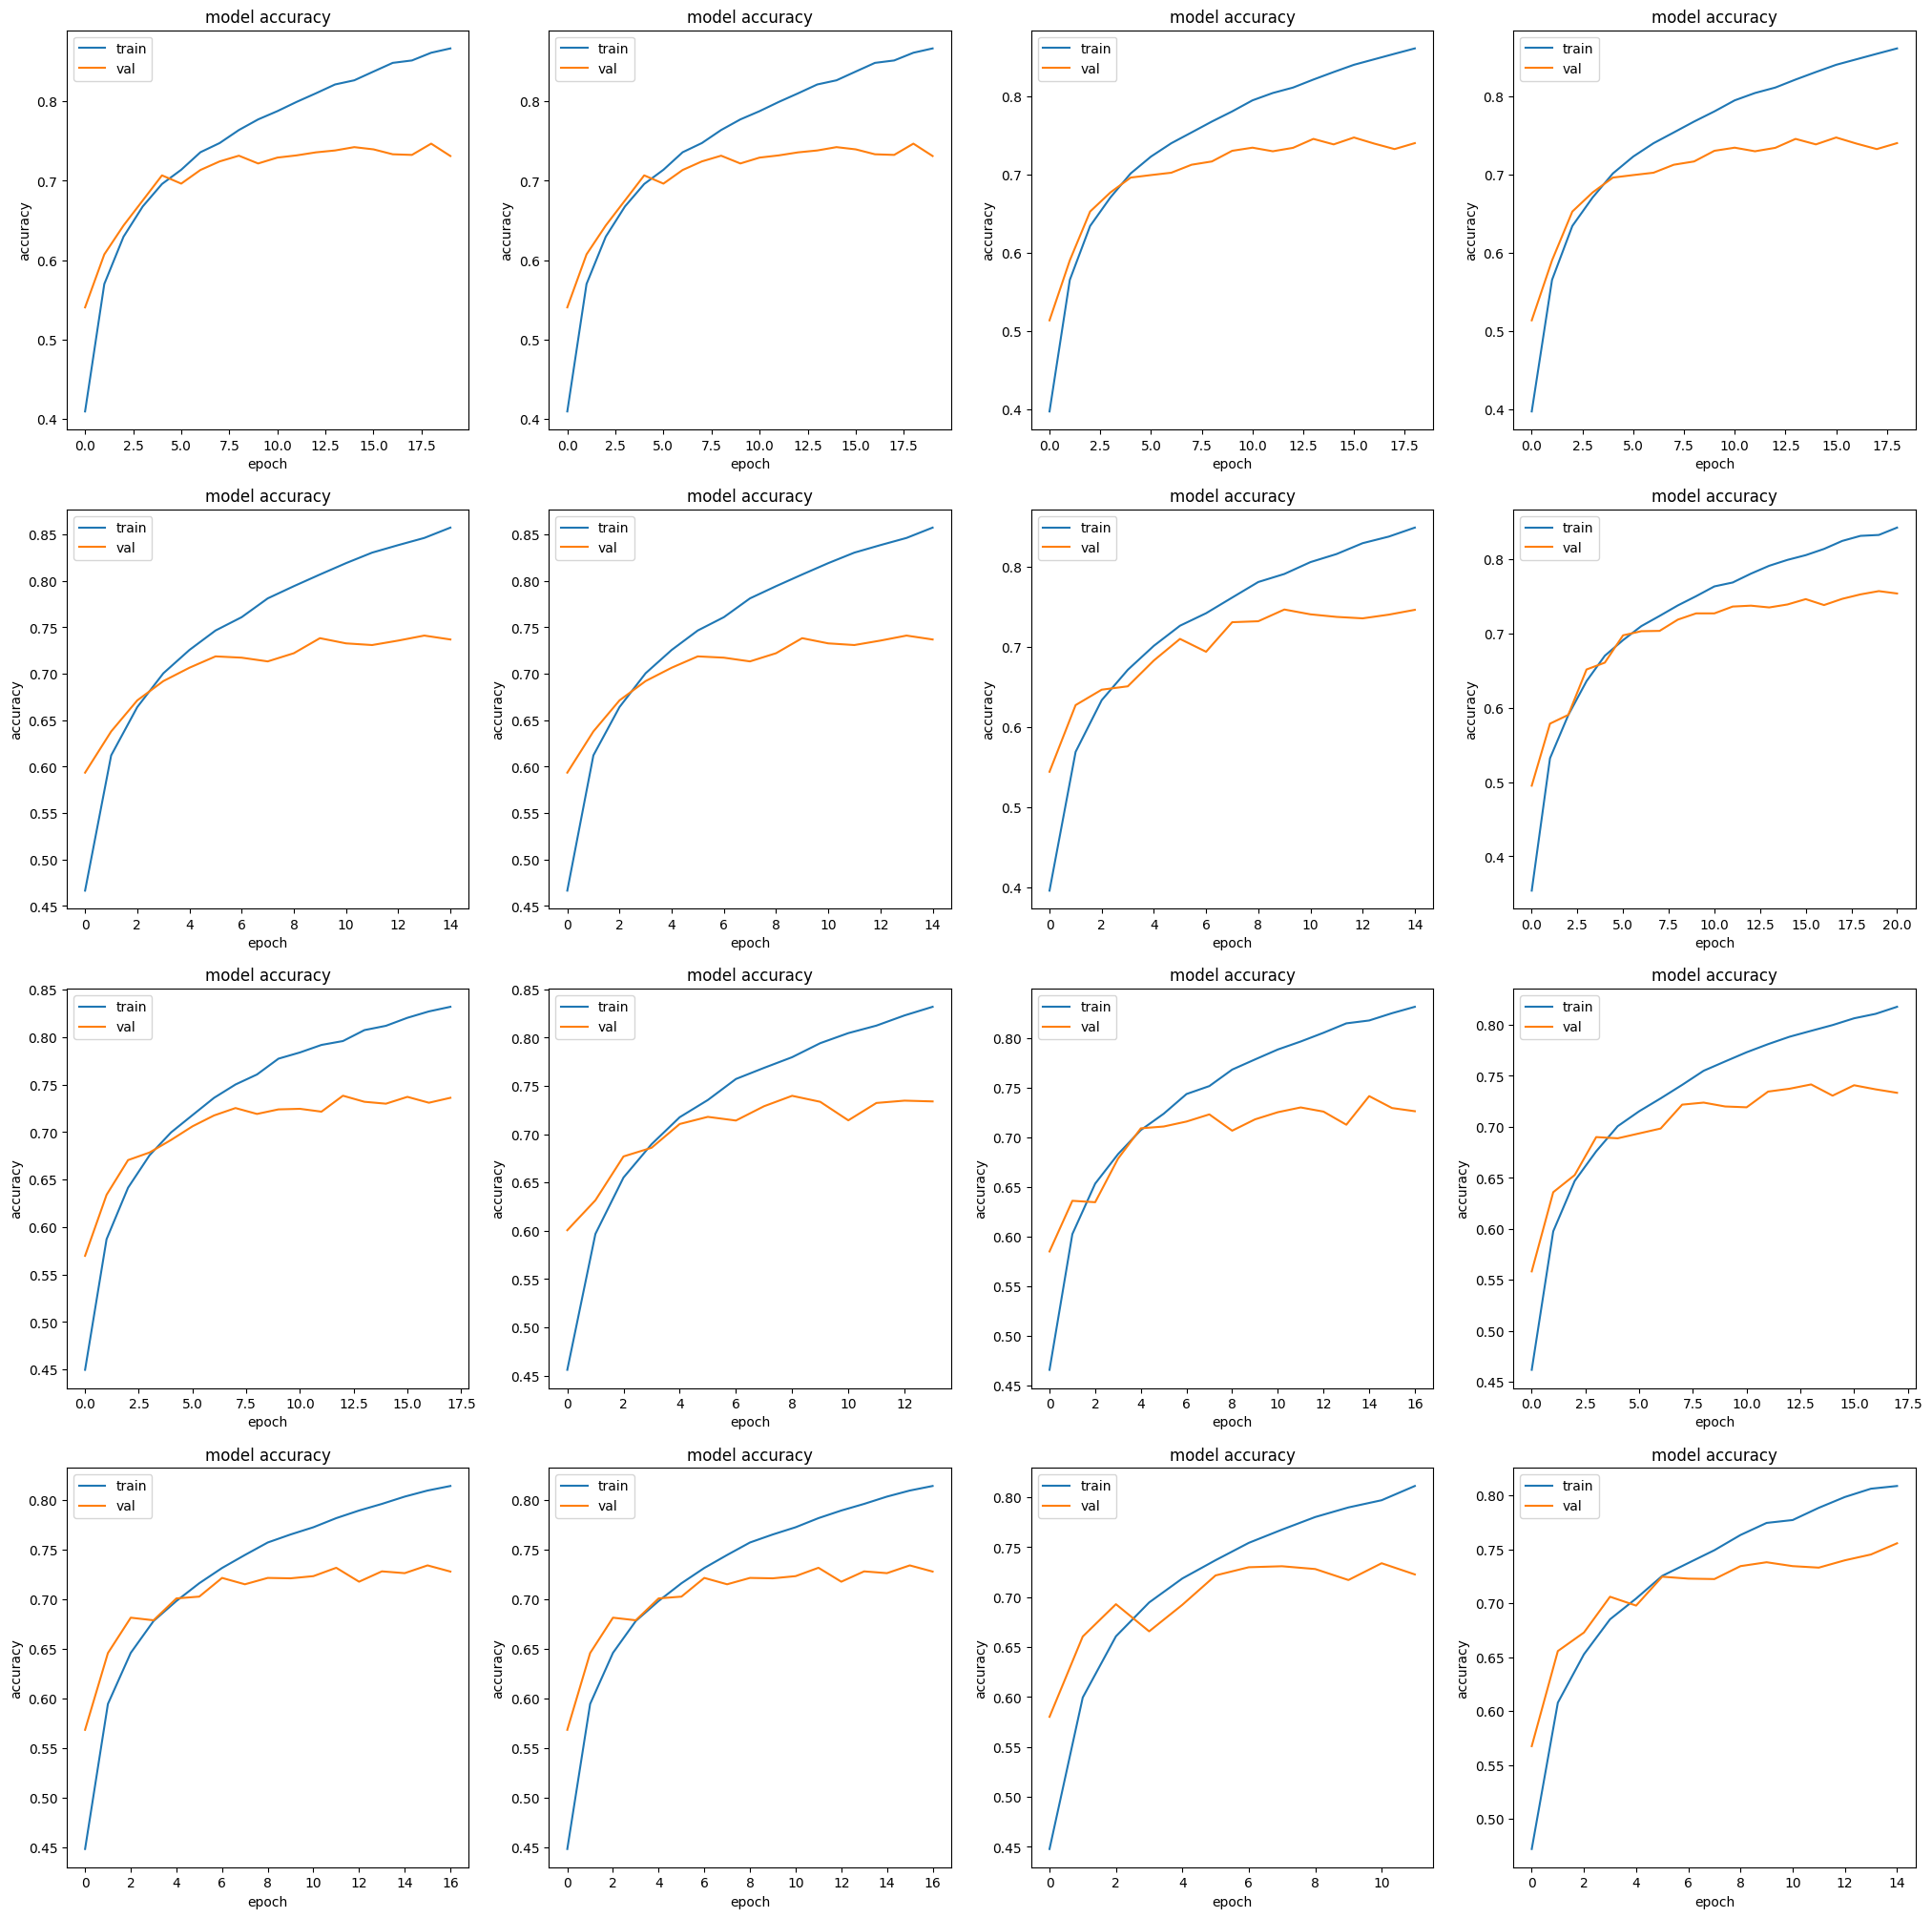

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))

m = 0

for i in range(4):
    for j in range(4):
        axes[i, j].plot(models[m]["accuracy"])
        axes[i, j].plot(models[m]["val_accuracy"])
        axes[i, j].set_title('model accuracy')
        axes[i, j].set_ylabel('accuracy')
        axes[i, j].set_xlabel('epoch')
        axes[i, j].legend(['train', 'val'], loc='upper left')

        m += 1

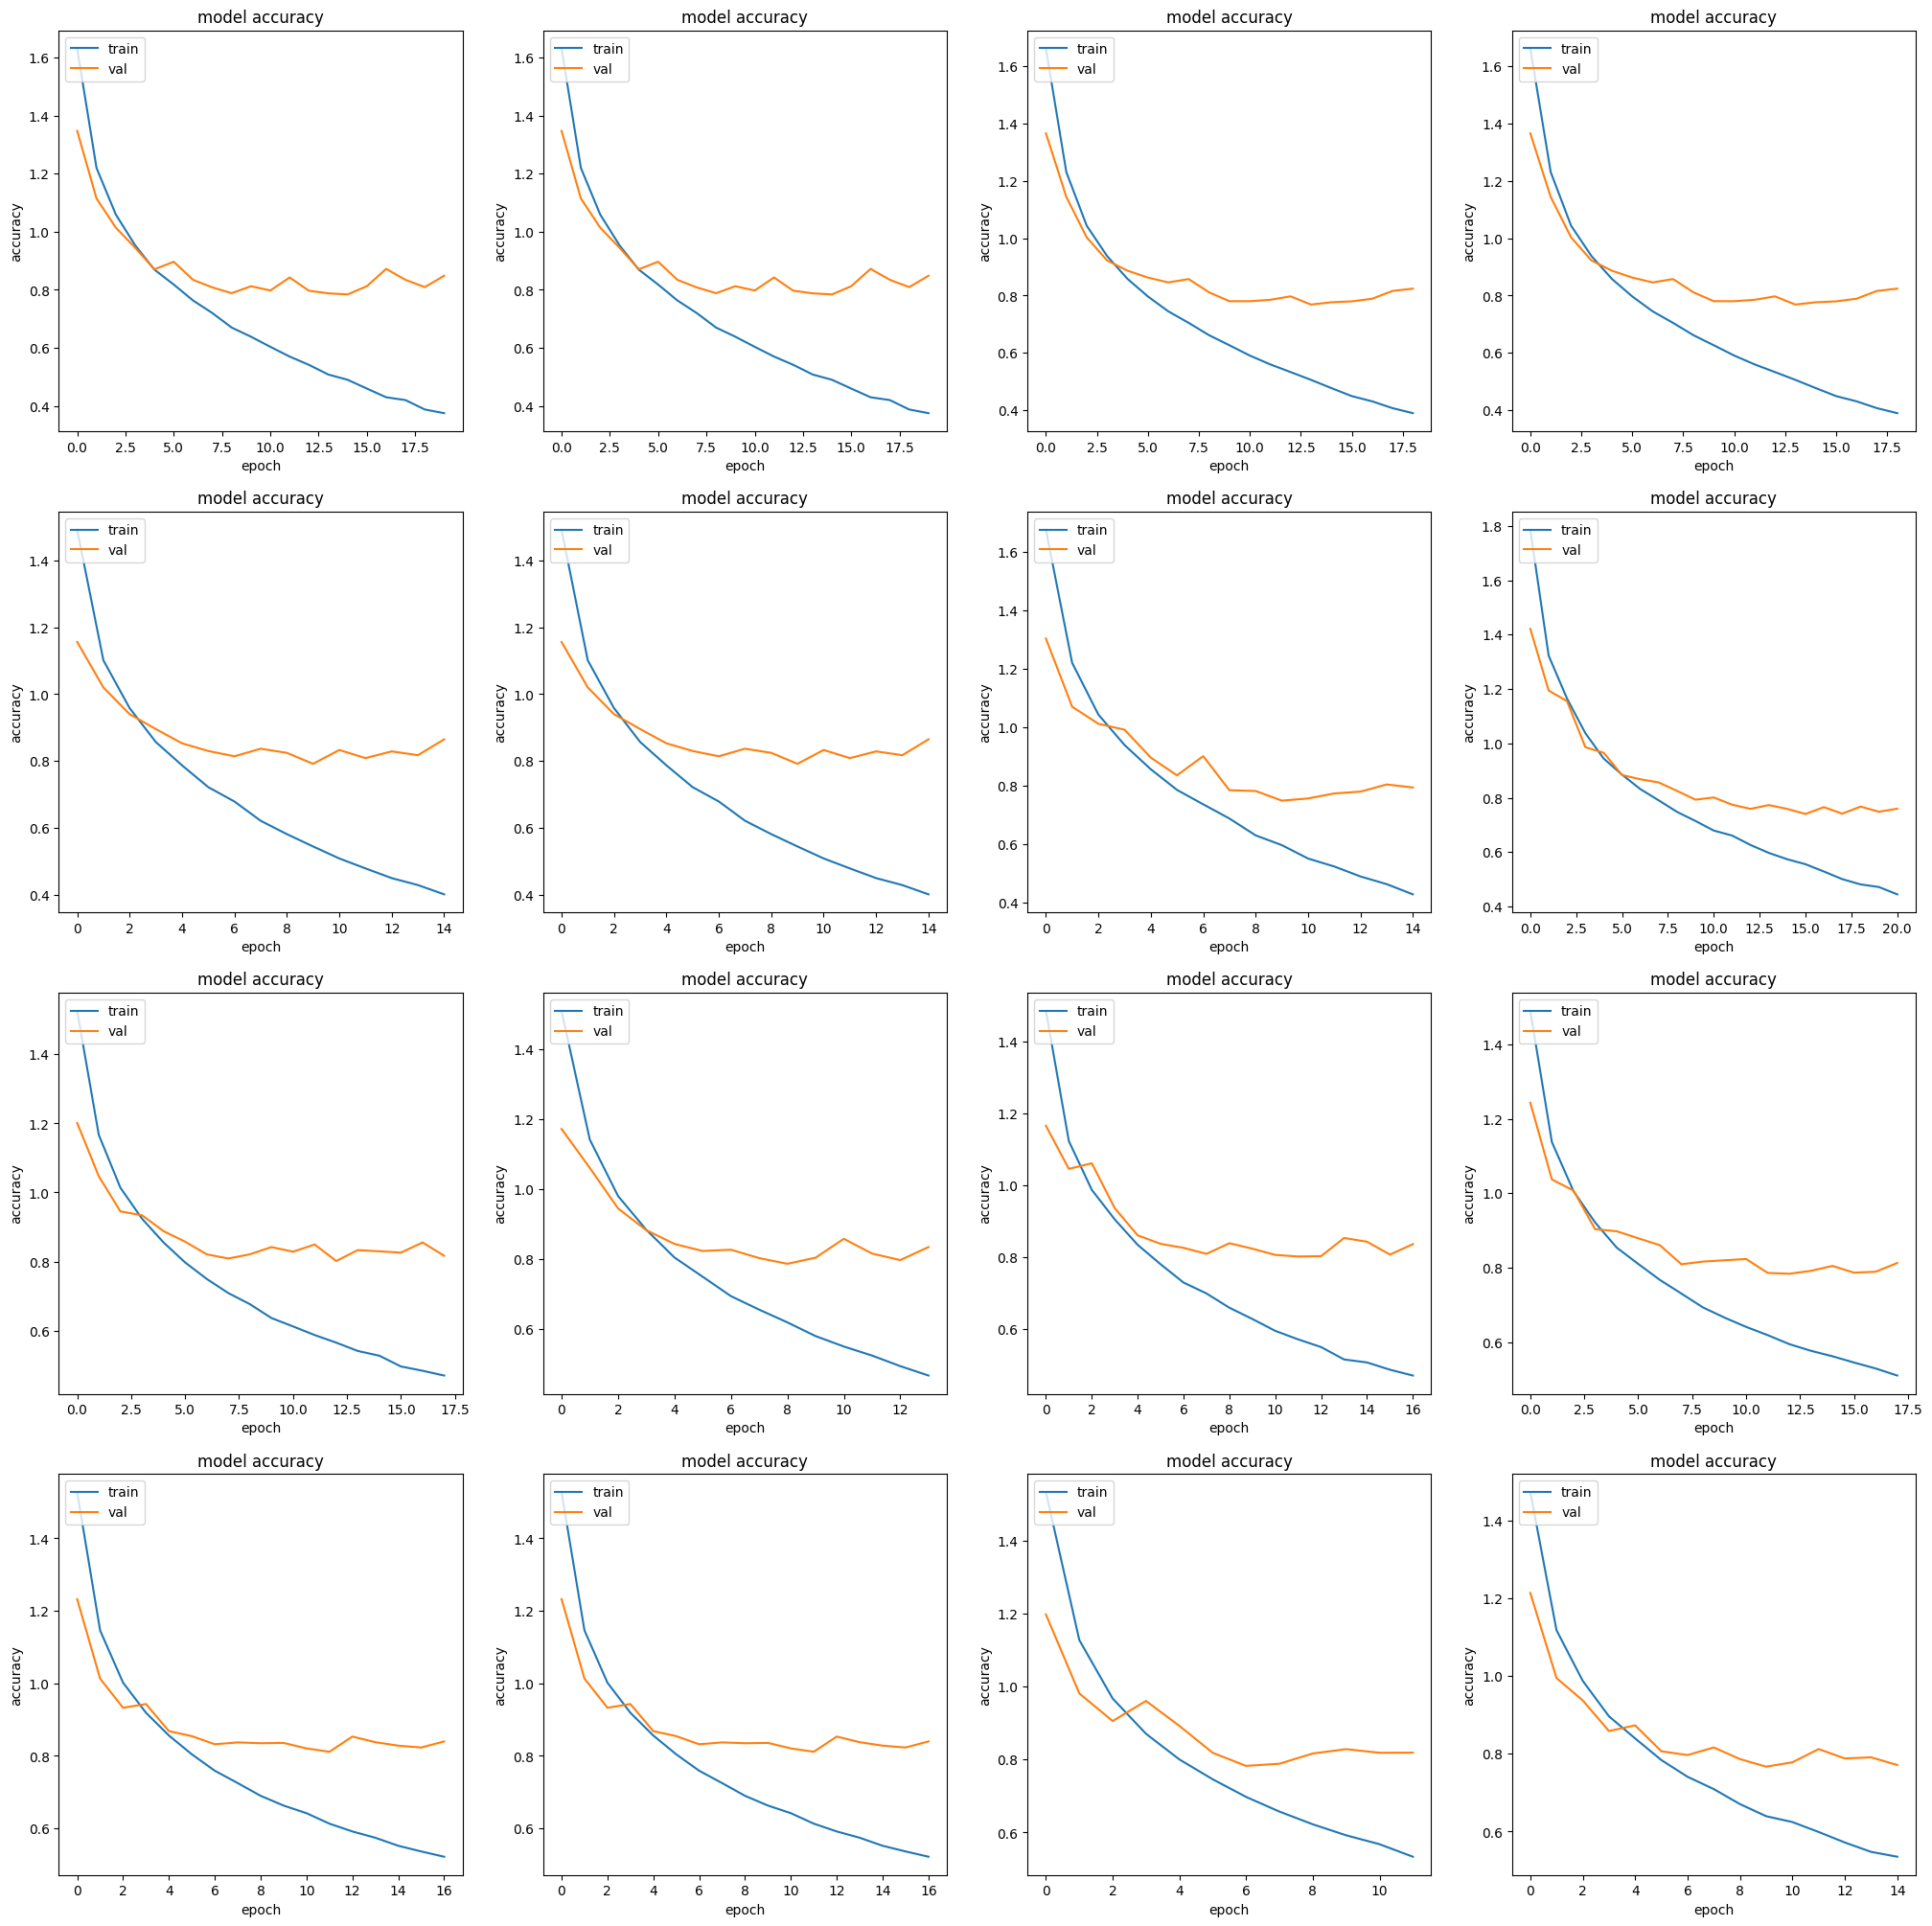

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))

m = 0

for i in range(4):
    for j in range(4):
        axes[i, j].plot(models[m]["loss"])
        axes[i, j].plot(models[m]["val_loss"])
        axes[i, j].set_title('model accuracy')
        axes[i, j].set_ylabel('accuracy')
        axes[i, j].set_xlabel('epoch')
        axes[i, j].legend(['train', 'val'], loc='upper left')

        m += 1